In [307]:
%run "rossmann_01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int32         
 1   day_of_week                   1017209 non-null  int8          
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int32         
 5   open                          1017209 non-null  int8          
 6   promo                         1017209 non-null  int8          
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int8          
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

In [319]:
### Data Analisy Libraries ###
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime, time, date, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [320]:
df=data.copy()

In [321]:
df=df.loc[(df['sales']>0) & (df['open'] ==1)]

In [322]:
df=df[['sales','store']].set_index(df['date']).sort_index(ascending=True)

In [323]:
df.head()

,sales,store
date,,
2013-01-01,5961,1097
2013-01-01,4220,85
2013-01-01,6851,259
2013-01-01,17267,262
2013-01-01,3102,274


## Avarage Sales of Stores by day, month, year

In [324]:
#dados[['sales','store']].groupby(dados.index).mean()

In [325]:
dados = df.resample('W').mean().drop('store',axis=1)

In [326]:
dados

,sales
date,
2013-01-06,5844.181391
2013-01-13,7410.922244
2013-01-20,5167.257628
2013-01-27,6908.788866
2013-02-03,5771.347187
...,...
2015-07-05,8287.273958
2015-07-12,6164.003276
2015-07-19,7753.193053


In [327]:
#dados.fillna(0, inplace=True)

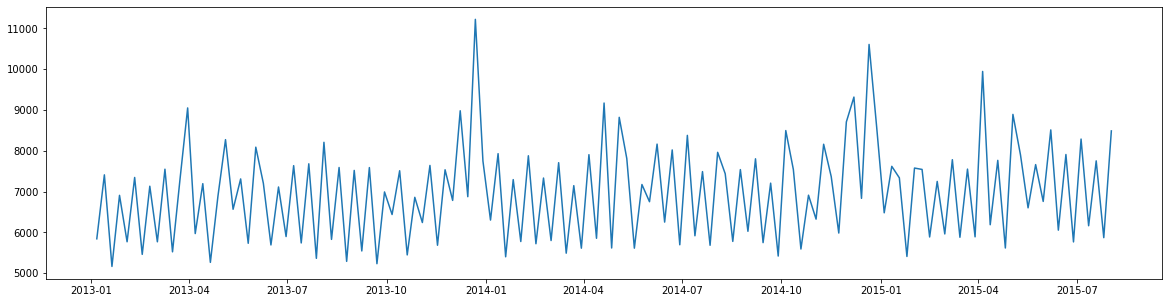

In [328]:
plt.figure(figsize=(20,5))
plt.plot(dados)

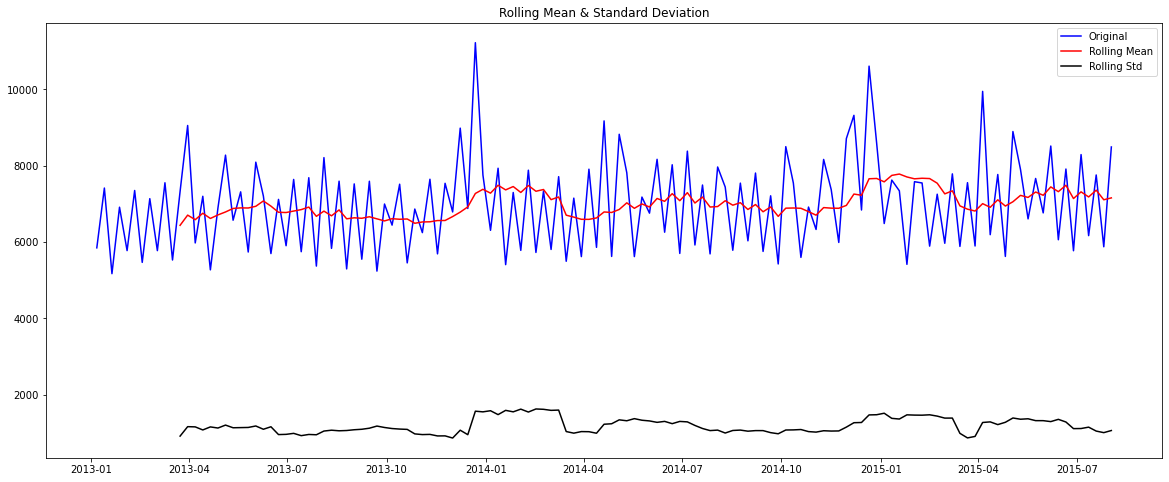

In [329]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
test_stationarity(dados)

In [353]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dados, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Ammount'])
for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value

print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic         -6.725479e+00
p-value                 3.398316e-09
Lags Used               1.000000e+00
Ammount                 1.330000e+02
Critical Value (1%)    -3.480500e+00
Critical Value (5%)    -2.883528e+00
Critical Value (10%)   -2.578496e+00
dtype: float64


<AxesSubplot:xlabel='date'>

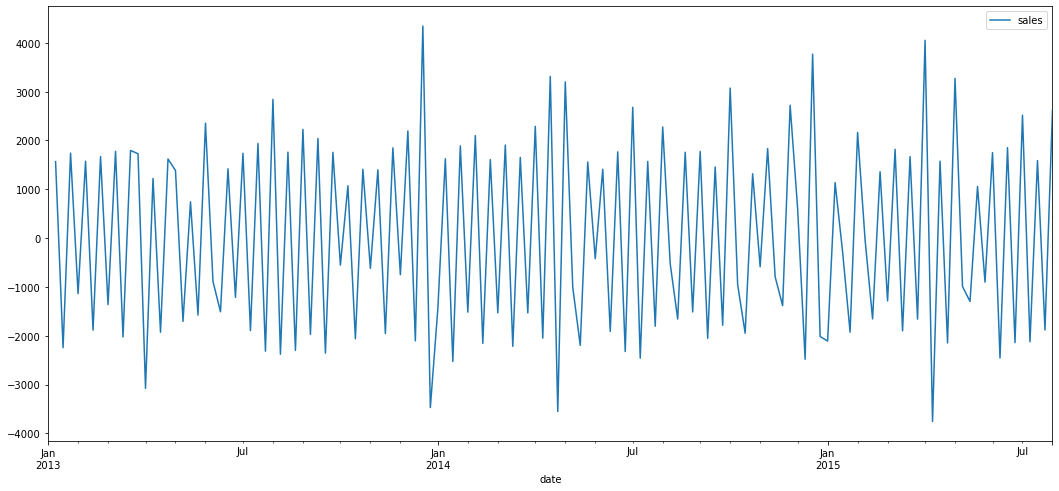

In [354]:
#Aplly d=1
dados.diff().plot(figsize=(18,8))

In [346]:
sarima = sm.tsa.statespace.SARIMAX(dados, order=(11,1,3), seasonal_order=(2,1,2,12), freq='W').fit()

C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [347]:
sarima.resid.describe()

count     135.000000
mean     -213.155306
std      1428.905777
min     -5305.248045
25%      -866.434199
50%      -245.932999
75%       419.198950
max      5844.181391
dtype: float64

In [350]:
print(f"SARIMA: Resid:{(sarima.resid **2).mean()}")

SARIMA: Resid:2072082.6679890605


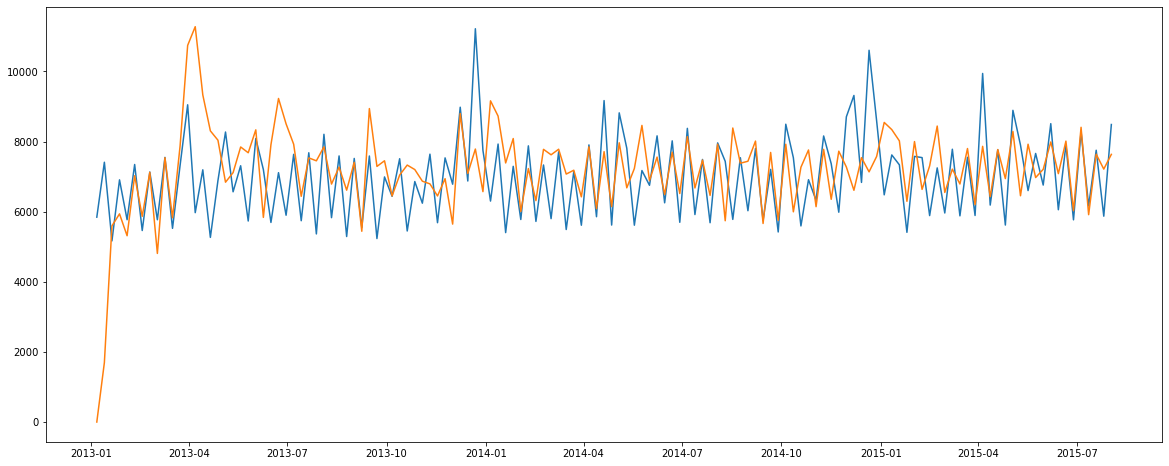

In [355]:
plt.figure(figsize=(20,8))
plt.plot(dados.sales)
plt.plot(sarima.predict(typ='levels'))

In [356]:
sarima.forecast()[0]

6930.0875472945245

In [357]:
print(sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2383      1.304     -0.949      0.342      -3.794       1.318
ar.L2         -0.5619      1.557     -0.361      0.718      -3.615       2.491
ar.L3          0.2105      0.712      0.295      0.768      -1.186       1.607
ar.L4          0.4123      0.830      0.497      0.619      -1.215       2.039
ar.L5          0.1707      0.586      0.292      0.771      -0.977       1.318
ar.L6          0.0093      0.536      0.017      0.986      -1.042       1.061
ar.L7         -0.2312      0.480     -0.481      0.630      -1.173       0.710
ar.L8         -0.2095      0.532     -0.394      0.694      -1.252       0.833
ar.L9          0.0511      0.487      0.105      0.916      -0.903       1.005
ar.L10         0.0843      0.452      0.187      0.852      -0.801       0.970
ar.L11         0.0394      0.408      0.096      0.9

# Train Test Split

In [358]:
train = dados.loc[dados.index < '2015-06-19']
test = dados.loc[dados.index >= '2015-06-19']

#y_train = train[target]
#X_train = train[default_features]#default_features, ts_features

#y_test = test[target]
#X_test = test[default_features]

#X_train.shape, y_train.shape, X_test.shape, y_test.shape
train.shape, test.shape

((128, 1), (7, 1))

In [359]:
sarima_312_train = sm.tsa.statespace.SARIMAX(train, order=(11,1,3), seasonal_order=(3,1,2,12), freq='W').fit()

C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [360]:
sarima_312_train.params

ar.L1      -1.478716e+00
ar.L2      -7.562440e-01
ar.L3       3.441973e-01
ar.L4       5.781821e-01
ar.L5       2.979097e-01
ar.L6       8.157350e-02
ar.L7      -2.134407e-01
ar.L8      -1.955432e-01
ar.L9       8.673889e-02
ar.L10      1.476773e-01
ar.L11      7.576279e-02
ma.L1       3.910849e-01
ma.L2      -3.490698e-01
ma.L3      -8.319933e-01
ar.S.L12   -9.479759e-01
ar.S.L24   -3.856350e-01
ar.S.L36   -1.861493e-01
ma.S.L12    4.452191e-02
ma.S.L24   -3.983812e-01
sigma2      2.345691e+06
dtype: float64

In [271]:
sarima_312_test = sm.tsa.statespace.SARIMAX(test, order=(11,1,3), seasonal_order=(3,1,2,12), freq='D').fit(sarima_312_train.params)

C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [272]:
sarima_312_test.params

ar.L1       2.059647e-01
ar.L2       4.196607e-01
ar.L3      -7.927975e-01
ar.L4      -2.577560e-01
ar.L5      -7.829274e-02
ar.L6      -1.355822e-01
ar.L7       3.550754e-01
ar.L8      -2.260020e-01
ar.L9      -3.774597e-01
ar.L10      3.518924e-01
ar.L11     -9.248093e-02
ma.L1      -4.075369e-01
ma.L2      -3.632103e-01
ma.L3       9.157946e-01
ar.S.L12   -8.076876e-01
ar.S.L24   -2.836873e-01
ar.S.L36   -7.297550e-02
ma.S.L12   -2.808759e-02
ma.S.L24   -5.696401e-02
sigma2      3.603003e+06
dtype: float64

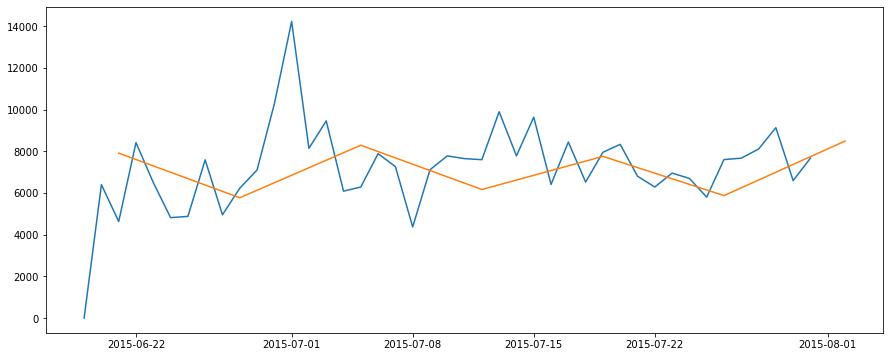

In [352]:
plt.figure(figsize=(15,6))
plt.plot(sarima_312_test.predict(typ='levels'))
plt.plot(test)

In [76]:
orders = [(2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 1, 5)]
best = 100_000_000
for order in orders:
    try:
        model_train = ARIMA(train, freq='D', order=order).fit()
        model_test = ARIMA(test, freq='D', order=order).fit(model_train.params)
        erro = (model_test.resid ** 2).mean()
        if erro < best:
            print(f'ARIMA{order}, erro={erro:.0f}')
            best = erro
    except:
        pass

ARIMA(2, 1, 1), erro=2751300
ARIMA(3, 1, 1), erro=2733074
ARIMA(4, 1, 1), erro=2726330


C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(5, 1, 1), erro=2717100


C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 2), erro=2697079


C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3), erro=2640186


C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4), erro=2485594


C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='day'>

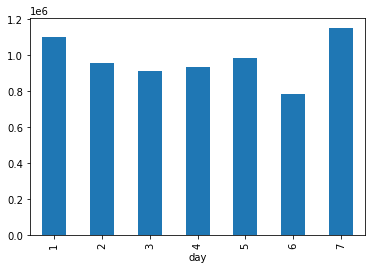

In [139]:
dados['sales'].groupby(dados.index.isocalendar().day).sum().plot(kind='bar')

<AxesSubplot:xlabel='date'>

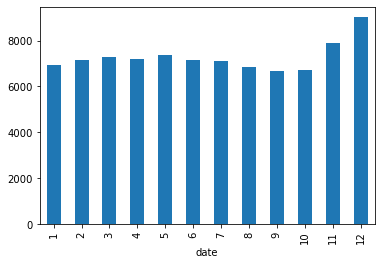

In [25]:
dados['sales'].groupby(dados.index.month).mean().plot(kind='bar')

In [178]:
dados['sales'].groupby(dados.index.month).mean().plot(kind='bar')

KeyError: 'sales'

<AxesSubplot:xlabel='day'>

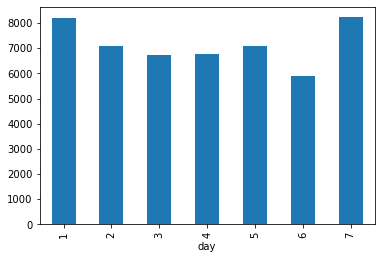

In [179]:
df['sales'].groupby(df.index.isocalendar().day).mean().plot(kind='bar')

<AxesSubplot:xlabel='day'>

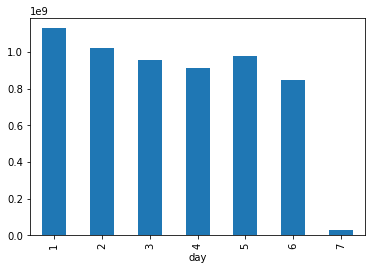

In [151]:
df['sales'].groupby(df.index.isocalendar().day).sum().plot(kind='bar')

In [152]:
#data_prep=data_prep.set_index(data_prep['date'])
#data_prep=data_prep.sort_index()

In [204]:
resultado = seasonal_decompose(dados['sales'], period=12)

In [205]:
tendencia= resultado.trend
seasom=resultado.seasonal
resultado.resid


date
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
              ..
2015-07-27   NaN
2015-07-28   NaN
2015-07-29   NaN
2015-07-30   NaN
2015-07-31   NaN
Freq: D, Name: resid, Length: 942, dtype: float64

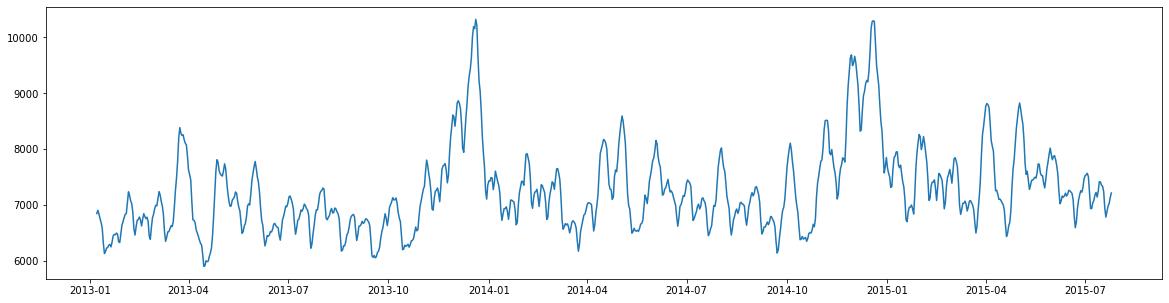

In [209]:
plt.figure(figsize=(20,5))
plt.plot(tendencia)

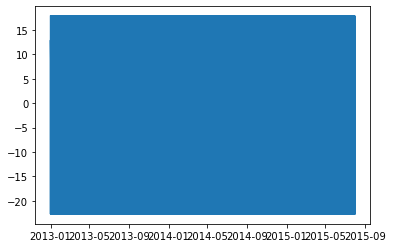

KeyboardInterrupt: 

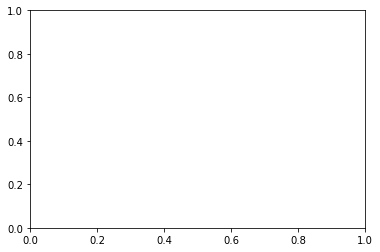

na média o mês de dezembro é o mais lucrativo e o de janeiro o menos.
Segunda é o dia mais lucrativo, exceto quando comparado com as lojas que abrem aos domingos, no entanto são poucas as lojas da Rossman que abre aos domingos.


## Mean Best Store

<AxesSubplot:xlabel='date'>

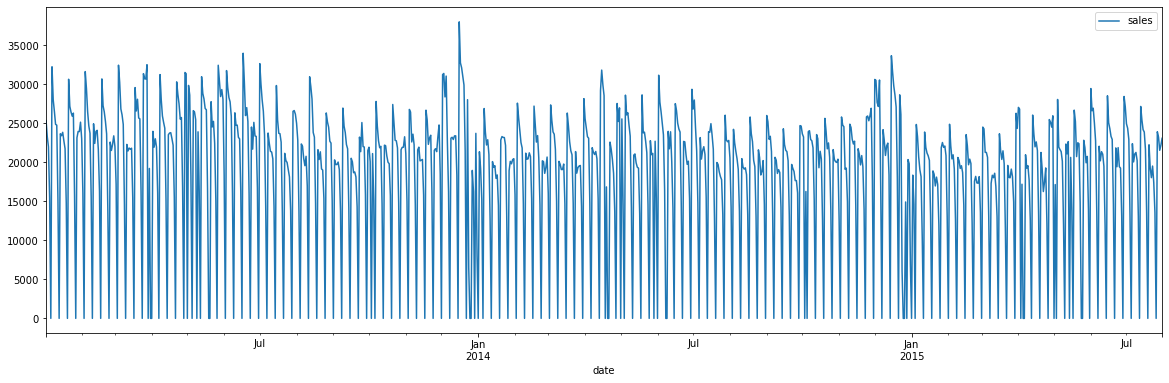

In [129]:
store_817 = df.loc[(df['store']== 817),['sales']]
store_817 = store_817.resample('D').sum()
store_817.plot(figsize=(20,6))

<AxesSubplot:xlabel='date'>

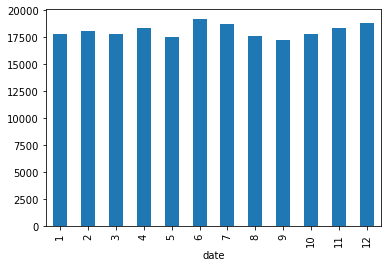

In [130]:
store_817['sales'].groupby(store_817.index.month).mean().plot(kind='bar')

<AxesSubplot:xlabel='day'>

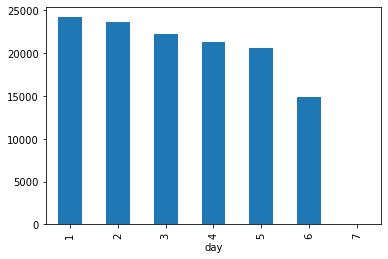

In [131]:
store_817['sales'].groupby(store_817.index.isocalendar().day).mean().plot(kind='bar')

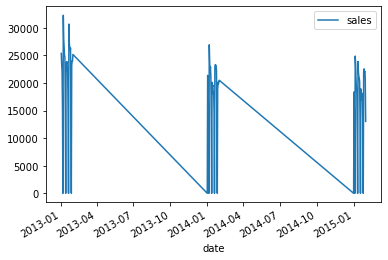

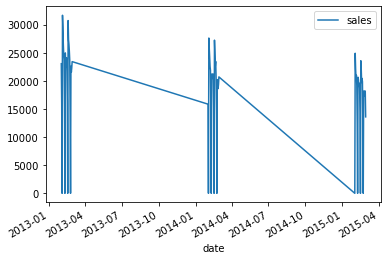

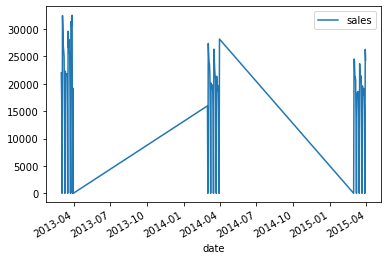

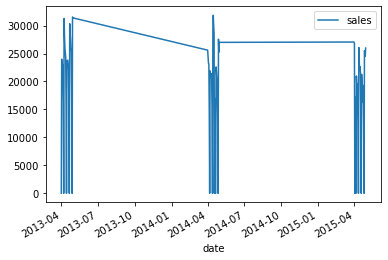

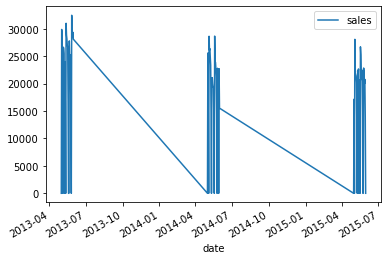

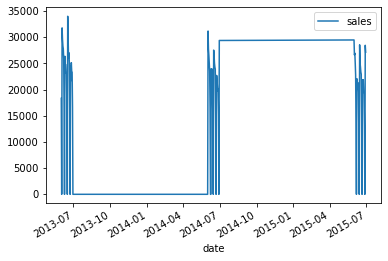

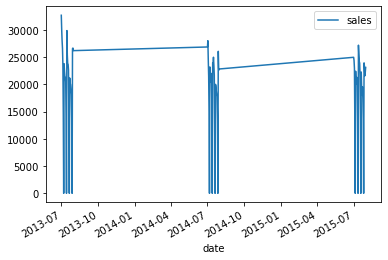

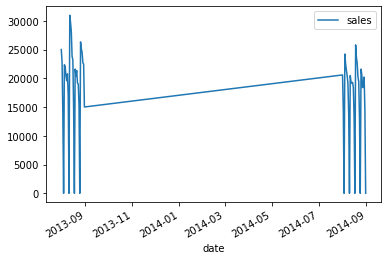

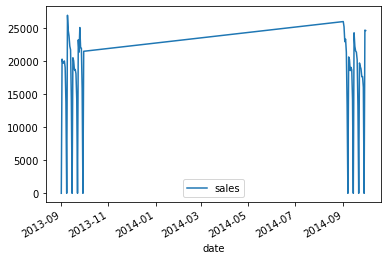

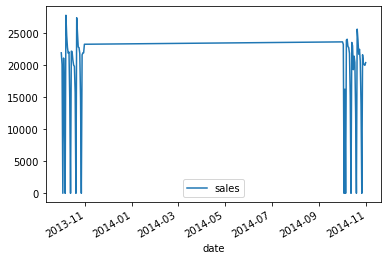

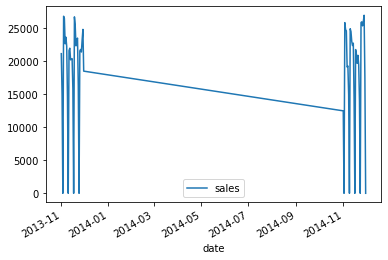

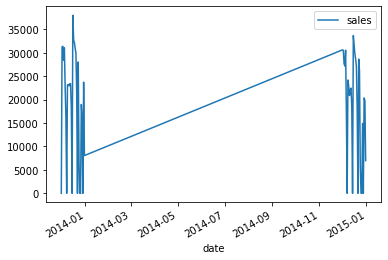

In [132]:
store_817.groupby(store_817.index.month).plot()
store_817_w=store_817.resample("M")

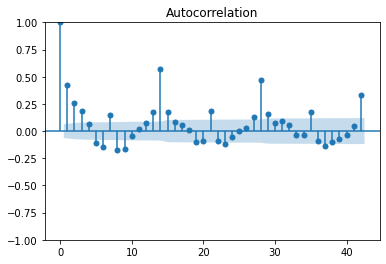

In [23]:
plot_acf(dados.sales, lags=6*7)
plt.show()

C:\Users\Alysson\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


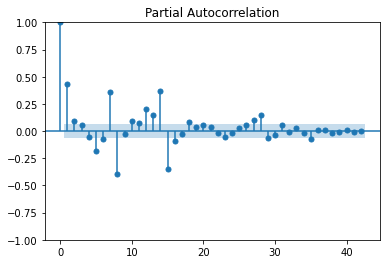

In [24]:
plot_pacf(dados.sales, lags=6*7)
plt.show()

In [ ]:
data_prep['sales'].loc[data_prep['sales']< 6.4].plot(style='.', figsize=(20, 5), title='Outliers');
outlier_inf= (data_prep['sales']< 6.4)
data_prep=data_prep[~outlier_inf]

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=6*7*1115, gap=0)

In [ ]:
# df = data_prep.set_index(data_prep['date'])
# df = df.sort_index()

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data_prep):
    train = data_prep.iloc[train_idx]
    test = data_prep.iloc[val_idx]
    train['sales'].plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['sales'].plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
def add_lags(df):
    target_map = df['sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df

In [ ]:
data_prep = add_lags(data_prep)

In [ ]:
data_prep.columns

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=6*7*1115, gap=0)
data_prep = data_prep.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data_prep):
    train = data_prep.iloc[train_idx]
    test = data_prep.iloc[val_idx]

    ts_features = ['store',
                     'day_of_week',
                     'day',
                     'month',
                     'year',
                     'dayofyear',
                     'competition_distance',
                     'competition_open_since',
                     'promo',
                     'is_promo_month',
                     'promo2',
                     #'competition_open_since_month','competition_open_since_year',
                     'promo2_since_week',
                     'school_holiday', 
                     #'state_holiday_Christmas',
                     #'state_holiday_Easter Holiday',
                     #'state_holiday_Public Holiday',
                     #'state_holiday_Regular Day',                     
                     'assortment',
                      'store_type',
                     #'store_type_a',
                     #'store_type_b',
                     #'store_type_c',
                     #'store_type_d'
                      'lag1',
                      'lag2',
                      'lag3'
                    ]

    X_train = train[ts_features]
    y_train = train[target]
    X_test = test[ts_features]
    y_test = test[target]
   
    xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=20)
    y_pred = xgb.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(np.mean((y_test)/((y_pred)-1) ** 2))#np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)   
    

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

In [ ]:
# Retrain on all data
#df = create_features(df)

X_all = data_prep[ts_features]
y_all = data_prep[target]

xgb.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=20)

In [ ]:
data_prep.index.max()

In [ ]:
future = pd.date_range('2014-07-31','2015-09-30', freq='D')

In [ ]:
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
data_prep['isFuture'] = False
df_and_future = pd.concat([data_prep, future_df])
#df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
df_and_future